# Football Header Impact Classification Project

# Libraries

In [ ]:
# Import des bibliothèques
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, confusion_matrix, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data

In [ ]:
# --- 1. Charger le CSV
df = pd.read_csv("HeadingFeatures.csv")

# Sélection des variables explicatives et de la cible
X = df[["1_Dist_Bef_Head", "2_Fli_Bef_Head", "3_Fli_Aft_Head", "4_Dist_Aft_Head", "5_Head_Type"]]
Y = df["PLA (Based on Median)"].values  # 0 = low, 1 = high acceleration
# Conversion explicite de la cible en 0/1
Y = df["PLA (Based on Median)"].map({"Low": 0, "High": 1}).values

# Variable cible déséquilibrée (10 "forts" impacts)
# Y = np.array([1]*10 + [0]*49)

# Defining models and hyperparameters

In [ ]:
# --- 2. Définir les modèles et hyperparamètres ---
models = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'class_weight': ['balanced']
    }),
    'LogisticRegression': (LogisticRegression(solver='liblinear'), {
        'C': [0.1, 1, 10],
        'class_weight': ['balanced']
    }),
    'SVM': (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced']
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'scale_pos_weight': [5.0]  # approx inverse class frequency
    })
}

# Nested Cross-Validation

In [ ]:
outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
results = []

for model_name, (clf, param_grid) in models.items():
    outer_scores = []
    for train_idx, test_idx in outer.split(X, Y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        # Inner CV pour le tuning des hyperparamètres
        grid = GridSearchCV(clf, param_grid, cv=3, scoring='recall', n_jobs=-1)
        grid.fit(X_train, Y_train)
        best_model = grid.best_estimator_

        # Prédictions probabilistes pour tuning du seuil
        probas = best_model.predict_proba(X_test)[:, 1]
        best_recall, best_f1, best_thresh = 0, 0, 0.5

        for t in np.arange(0.1, 0.9, 0.05):
            preds = (probas > t).astype(int)
            r = recall_score(Y_test, preds)
            f = f1_score(Y_test, preds)
            if r > best_recall or (r == best_recall and f > best_f1):
                best_recall, best_f1, best_thresh = r, f, t

        outer_scores.append((best_recall, best_f1, best_thresh))

    recalls, f1s, threshs = zip(*outer_scores)
    results.append({
        'Model': model_name,
        'Mean Recall': np.mean(recalls),
        'Mean F1': np.mean(f1s),
        'Avg Threshold': np.mean(threshs)
    })

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:17:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:17:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:17:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:17:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:17:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

# Performances summary

In [ ]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Mean Recall', ascending=False))

                Model  Mean Recall   Mean F1  Avg Threshold
0        RandomForest          1.0  0.826176           0.28
1  LogisticRegression          1.0  0.753307           0.26
2                 SVM          1.0  0.781878           0.26
3             XGBoost          1.0  0.759337           0.41


# Confusion Matrix

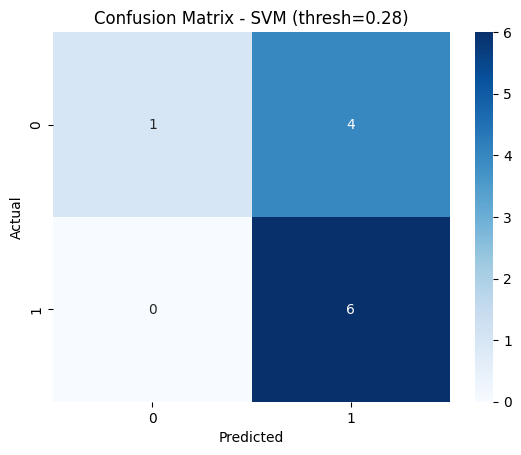

In [ ]:
# Pour le meilleur modèle et seuil optimal :
final_model = best_model  # à ajuster si tu veux spécifier SVM
final_thresh = 0.28       # seuil optimal du SVM
final_preds = (final_model.predict_proba(X_test)[:, 1] > final_thresh).astype(int)
cm = confusion_matrix(Y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM (thresh=0.28)')
plt.show()

# Graphical results

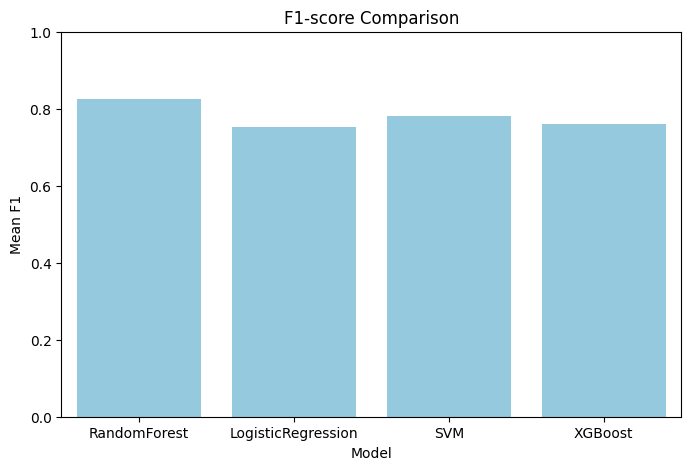

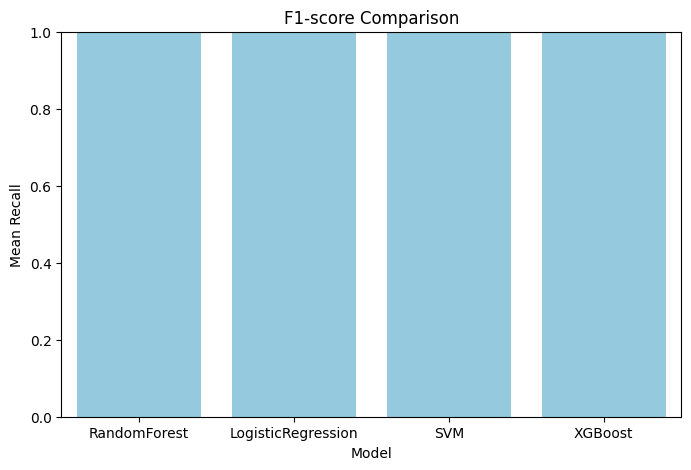

In [ ]:
#F-Mesure
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Mean F1', color='skyblue')
plt.title('F1-score Comparison')
plt.ylim(0, 1)
plt.show()

# Recall
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Mean Recall', color='skyblue')
plt.title('F1-score Comparison')
plt.ylim(0, 1)
plt.show()

# Features classification

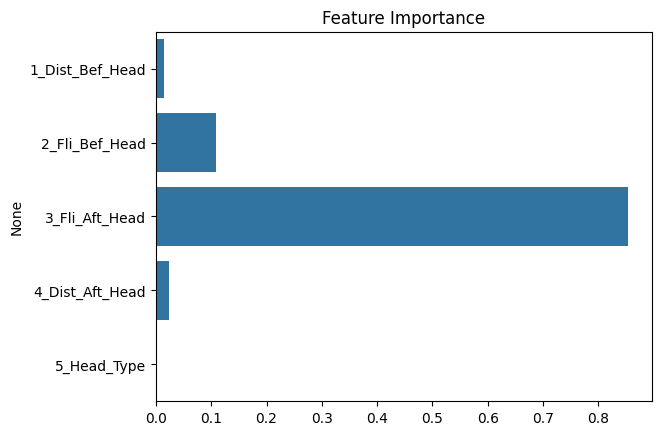

In [ ]:
importances = final_model.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

# Ablation study : testing features combinations

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

ablations = []
feature_names = ["1_Dist_Bef_Head", "2_Fli_Bef_Head", "3_Fli_Aft_Head", "4_Dist_Aft_Head", "5_Head_Type"]
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for k in range(1, len(feature_names) + 1):
    for subset in combinations(feature_names, k):
        X_sub = df[list(subset)]

        recalls = []
        f1s = []
        for train_idx, test_idx in kfold.split(X_sub, Y):
            X_train, X_test = X_sub.iloc[train_idx], X_sub.iloc[test_idx]
            Y_train, Y_test = Y[train_idx], Y[test_idx]

            model.fit(X_train, Y_train)
            probas = model.predict_proba(X_test)[:, 1]

            best_recall, best_f1 = 0, 0
            for t in np.arange(0.1, 0.9, 0.05):
                preds = (probas > t).astype(int)
                r = recall_score(Y_test, preds)
                f = f1_score(Y_test, preds)
                if r > best_recall or (r == best_recall and f > best_f1):
                    best_recall, best_f1 = r, f

            recalls.append(best_recall)
            f1s.append(best_f1)

        ablations.append({
            'Features': subset,
            'Mean Recall': np.mean(recalls),
            'Mean F1': np.mean(f1s),
            'Num Features': k
        })

ablation_df = pd.DataFrame(ablations).sort_values(by='Mean Recall', ascending=False)
print(ablation_df[['Features', 'Mean Recall', 'Mean F1']])


                                             Features  Mean Recall   Mean F1
0                                  (1_Dist_Bef_Head,)     1.000000  0.688545
1                                   (2_Fli_Bef_Head,)     1.000000  0.766494
2                                   (3_Fli_Aft_Head,)     1.000000  0.759510
3                                  (4_Dist_Aft_Head,)     1.000000  0.739827
4                                      (5_Head_Type,)     1.000000  0.749216
5                   (1_Dist_Bef_Head, 2_Fli_Bef_Head)     1.000000  0.774681
6                   (1_Dist_Bef_Head, 3_Fli_Aft_Head)     1.000000  0.759510
8                      (1_Dist_Bef_Head, 5_Head_Type)     1.000000  0.749216
9                    (2_Fli_Bef_Head, 3_Fli_Aft_Head)     1.000000  0.818333
10                  (2_Fli_Bef_Head, 4_Dist_Aft_Head)     1.000000  0.781878
11                      (2_Fli_Bef_Head, 5_Head_Type)     1.000000  0.808039
13                      (3_Fli_Aft_Head, 5_Head_Type)     1.000000  0.759510

## Corrélation entre features

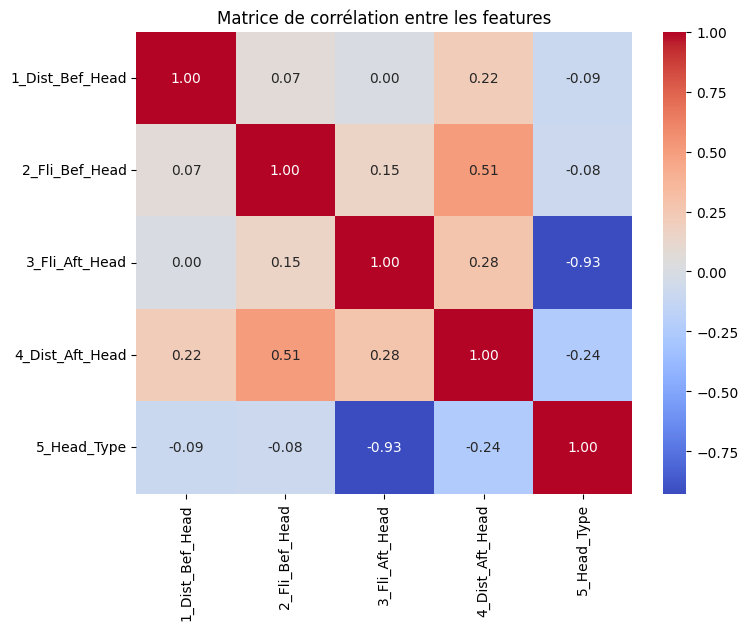

In [ ]:
# --- Corrélation entre les features ---
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation entre les features")
plt.show()

## Coefficients du modèle linéaire

In [ ]:
# --- Coefficients du modèle SVM linéaire ---
if isinstance(final_model, SVC) and final_model.kernel == 'linear':
    coef = final_model.coef_.flatten()
    coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coef})
    coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title("Poids des variables dans l'hyperplan du SVM linéaire")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Coefficients de l'équation de l'hyperplan SVM :")
    print(coef_df)
else:
    print("⚠️ Le modèle SVM sélectionné n'est pas linéaire, pas d'hyperplan interprétable directement.")

⚠️ Le modèle SVM sélectionné n'est pas linéaire, pas d'hyperplan interprétable directement.
